In [1]:
import numpy as np

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Set up retina
r_sampling = 250  # spatial sampling of retina
xhi = 1500
yhi = 1500
r = e2cm.Retina(sampling=r_sampling, xlo=-xhi, xhi=xhi, ylo=-yhi, yhi=yhi)

In [3]:
# Set up electrode array
dist = 100  # distance of electrode array to retina (um)
curr_thresh = e2cm.distance2threshold(dist)  # corresponding threshold current
print('threshold current = %.2f uA' % curr_thresh)

implant = e2cm.ElectrodeArray('epiretinal', [260], [0], [0], [dist])

# Set up temporal model
tsample = 5e-6
tm = ec2b.TemporalModel(tsample, asymptote=1, shift=15)

threshold current = 21.24 uA


In [4]:
# Pulse train used in Nanduri et al. (2012)
def get_pulse_train(freq, curr, tsample):
    return e2cm.Psycho2Pulsetrain(freq=freq, amp=curr,
                                  dur=0.5, pulse_dur=0.45/1000, interphase_dur=0.45/1000,
                                  delay=0, tsample=tsample, pulsetype='cathodicfirst')

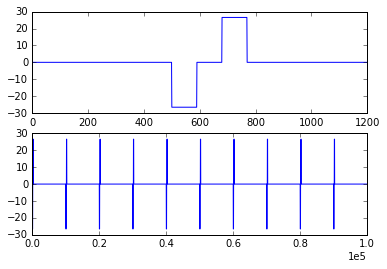

In [5]:
pulse_train = get_pulse_train(20, 1.25 * curr_thresh, tsample)
plt.subplot(211)
plt.plot(pulse_train.data[9500:10700])
plt.subplot(212)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.plot(pulse_train.data)

In [6]:
# Nanduri 2012 data

# input amplitude values (x threshold) and expected output (brightness)
all_amps = np.array([1.25, 1.5, 2, 4, 6]) * curr_thresh
out_amps = np.array([10, 15, 18, 19, 19])

# input frequency values and expected output
all_freqs = np.array([13, 20, 27, 40, 80, 120])
out_freqs = np.array([7.3, 10, 13, 19, 34, 51])

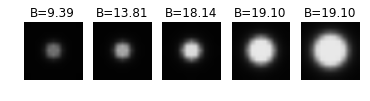

In [7]:
# Run the model on different amplitude values.
# We use current spread instead of effective current spread (use_ecs=False) in order to simulate the
# Nanduri conditions.
bright_amp = []
for i, ampl in enumerate(all_amps):
    pt = get_pulse_train(20, ampl, tsample)
    resp = ec2b.pulse2percept([pt], implant, 'NFL', r, tm, use_ecs=False, n_jobs=8, dojit=True, tol=0.01)
    bright_amp.append(resp.data.max())
    
    plt.subplot(1, len(all_amps), i + 1)
    frame = ec2b.get_brightest_frame(resp)
    plt.imshow(frame.data, cmap='gray', vmin=0, vmax=21)
    plt.axis('off')
    plt.title("B={:.2f}".format(frame.data.max()))
plt.savefig('size-amps.png')

bright_amp = np.array(bright_amp)

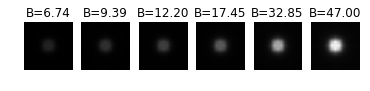

In [8]:
# Run the model on different frequency values
bright_freq = []
for i, freq in enumerate(all_freqs):
    pt = get_pulse_train(freq, 1.25 * curr_thresh, tsample)
    resp = ec2b.pulse2percept([pt], implant, 'NFL', r, tm, use_ecs=False, n_jobs=8, dojit=True, tol=0.01)
    bright_freq.append(resp.data.max())
    plt.subplot(1, len(all_freqs), i + 1)

    frame = ec2b.get_brightest_frame(resp)
    plt.imshow(frame.data, cmap='gray', vmin=0, vmax=50)
    plt.axis('off')
    plt.title("B={:.2f}".format(frame.data.max()))
plt.savefig('size-freqs.png')

bright_freq = np.array(bright_freq)

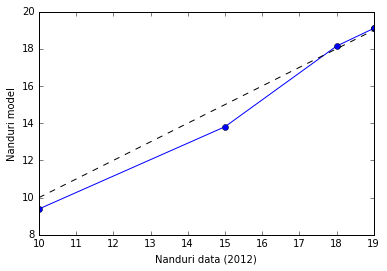

In [9]:
plt.plot(out_amps, bright_amp, 'o-')
plt.plot([out_amps[0], out_amps[-1]], [out_amps[0], out_amps[-1]], '--k')
plt.xlabel('Nanduri data (2012)')
plt.ylabel('Nanduri model')

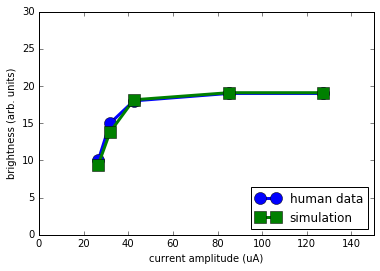

In [10]:
plt.plot(all_amps, out_amps, '-o', linewidth=3, markersize=12, label='human data')
plt.plot(all_amps, bright_amp, '-s', linewidth=3, markersize=12, label='simulation')
plt.xlabel('current amplitude (uA)')
plt.ylabel('brightness (arb. units)')
plt.legend(loc='lower right')
plt.ylim(0, 30)
plt.xlim(0, 150)
plt.savefig('nanduri-amps.png')

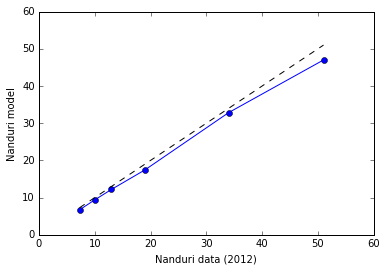

In [11]:
plt.plot(out_freqs, bright_freq, 'o-')
plt.plot([out_freqs[0], out_freqs[-1]], [out_freqs[0], out_freqs[-1]], '--k')
plt.xlabel('Nanduri data (2012)')
plt.ylabel('Nanduri model')

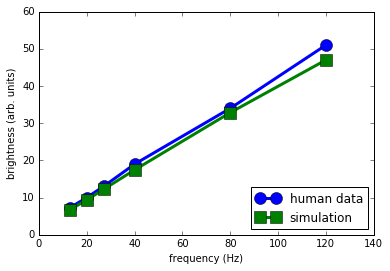

In [12]:
plt.plot(all_freqs, out_freqs, '-o', linewidth=3, markersize=12, label='human data')
plt.plot(all_freqs, bright_freq, '-s', linewidth=3, markersize=12, label='simulation')
plt.xlabel('frequency (Hz)')
plt.ylabel('brightness (arb. units)')
plt.legend(loc='lower right')
plt.xlim(0, 140)
plt.savefig('nanduri-freqs.png')